## <font color='blue'>SME0104 - Cálculo Numérico</font>

### Primeiro Trabalho em Grupo 
#### Comparação de Métodos na Solução do Laplaciano em Grafos para propagação de informação

**Luis Gustavo Nonato**

------

Considere os arquivos `manh.el` e `manh.xy` que fornecem as arestas e as coordenadas dos vértices do grafo de ruas da ilha de Manhattan, NY (arquivos disponíveis para download no Google Drive).

O grafo de ruas possui diversas componentes conexas, considerando somente a maior componente conexa, você deve realizar as seguintes tarefas:
1. Selecione alguns vértices do grafo $v_{i_1},v_{i_2},\ldots,v_{i_k},\, k<<n$ ($n$ é o número de vértices na maior componente do grafo e $k$ é um número bem menor que $n$, $k=10$ por exemplo) e atribua valores distindos $c_{i_1},c_{i_2},\ldots,c_{i_k}$ a cada um dos vértices selecionados (por exemplo valores no intervalo (0,10]);
2. Construa a matriz Laplaciana $L$ do grafo de ruas;
3. Construa a matriz de penalidades $P$, sendo $P$ é uma matriz diagonal onde a entrada $P_{jj}=\alpha$ se $j$ corresponde ao índice de algum dos vértices escolhidos no item 1 acima ($\alpha=1.0e7$ por exemplo), sendo $P_{ii}=0$ caso contrário.
4. Construa um vetor $b$ da seguinte forma:
$$
b_{j} = \left\{\begin{matrix} c_{i_s} & \text{ se } j = i_s \\ 0 & \text{ caso contrário}\end{matrix}\right.
$$
5. Compare o tempo de solução do sistema
$$
(L+P)x = Px
$$
para os métodos:
    - Decomposição LU
    - Cholesky
    - Jacobi e Gaus-Seidel
    - Gradientes Conjugados
    
6. Refaça as tarefas com representação por matriz esparsa e matrizes cheias, comparando os resultados.

In [5]:
#Participantes: 
#Bruno da Freiria Mischiati Borges
#Davi Malaspina Fileti
#Gabriel Penido

# Solucao

#Importando as bibliotecas que serão utilizadas na solução do problema
import numpy as np
import networkx as nx
import scipy.linalg 
import scipy.sparse.linalg 
from copy import deepcopy
import matplotlib.pyplot as plt
import time

#Dois métodos de solução do laplaciano foram implementados pelo grupo ao invés do uso de alguma biblioteca.
#Esses métodos foram o método de Gauss-Seidel e o método de Gauss-Jacobi

#Código para o método de Gauss-Seidel
def gauss_seidel(A, b, tol, iterações, x):
    #x é a condição inicial
    iter1 = 0
    #Iteração
    for k in range(iterações):
        iter1 = iter1 + 1
        x_velho  = x.copy()
        
        #Aplicando o loop sobre as linhas 
        for i in range(A.shape[0]):
            x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_velho[(i+1):])) / A[i ,i]
            
        #Condição de parada
        #maior_elemento corresponde ao valor absoluto do maior elemento do vetor.
        
        maior_elemento = max(abs((x - x_velho)))/max(abs(x_velho))   
        if  maior_elemento < tol:
            break
    
           
    return x

#Código para o método de Gauss-Jacobi
#O número de iterações utilizadas nesta implementação foram 10**4
def jacobi(A,b):
    linha, coluna = np.shape(A)
    s = np.zeros((linha,coluna))
    g = np.zeros(linha)

    for i in range (0,linha):
        s[i,:] = A[i,:]/A[i,i]
        g[i] = b[i]/A[i,i]
        s[i,i] = 0

        s = -s

        numero_iteracao = 10**4
        x = np.zeros(coluna)
        for i in range(numero_iteracao):
            x = np.dot(s,x)+g 

        return x

In [6]:
# Nesta célula de código, foi utilizada a biblioteca networkx para encontrar a maior componente conexa a partir dos dados fornecidos nos arquivos
# manh.el e manh.xy

#Criando o grafo que representa o arquivo manh.el
G = nx.read_edgelist("./dados/manh.el", create_using=nx.Graph, nodetype=int)
qnt = np.arange(G.number_of_nodes()+1)
mapping = dict(zip(G, qnt))
G = nx.relabel_nodes(G, mapping)

#Encontrando todas as componentes conexas que o grafo do arquivo manh.el possui
componentes = [G.subgraph(c).copy() for c in nx.connected_components(G)]
number_of_nodes = []
for i in range(len(componentes)):
  number_of_nodes.append(componentes[i].number_of_nodes())
index_maior_componente = number_of_nodes.index(max(number_of_nodes))

#Definindo o grafo da maior componente conexa
grafo_maior_componente = componentes[index_maior_componente]

#Criando a matriz Laplaciana e a matriz de penalidades a partir do grafo da maior componente conexa
matriz_laplaciana = nx.laplacian_matrix(grafo_maior_componente).todense()
matriz_penalidade = np.zeros( (len(matriz_laplaciana), len(matriz_laplaciana)))

#Atribuindo os valores da matriz de penalidades
penalidade = 10**4
for i in range(11):
  matriz_penalidade[i][i] = penalidade
b = np.zeros((len(matriz_penalidade),1))

b[0][0] = 250000
b[1][0] = 40000
b[2][0] = 10000
b[3][0] = 270000
b[4][0] = 380000
b[5][0] = 390000
b[6][0] = 70000
b[7][0] = 400000
b[8][0] = 130000
b[9][0] = 280000
b[10][0] = 200000

#Criando a matriz A que corresponde a soma da matriz Laplaciana com a matriz de penalidades
A = np.add(matriz_laplaciana,matriz_penalidade)



<class 'networkx.utils.decorators.argmap'> compilation 17:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [9]:
#Nesta célula de código iremos aplicar os métodos de solução sugeridos no trabalho a partir do uso da matriz A,  
#dos métodos iterativos implementados manualmente (Método de Gauss-seidel e Método de Gauss-Jacobi) e dos métodos utilizados das bibliotecas importadas 

# Método de decomposição LU (biblioteca scipy.linalg)
start_lu = time.time()
lu, piv = scipy.linalg.lu_factor(A)
x_lu = scipy.linalg.lu_solve((lu,piv),b)
end_lu = time.time()

# Método de decomposição de Cholesky (biblioteca scipy.linal)
start_cho = time.time()
c, low = scipy.linalg.cho_factor(A)
x_cho = scipy.linalg.cho_solve((c,low),b)
end_cho = time.time()

# Método de Gauss-Jacobi (implementado manualmente)
start_jaco = time.time()
x0 = np.ones((len(matriz_penalidade),1))
x_jaco = jacobi(A,b)
end_jaco = time.time()

# Método de Gauss-Seidel (implementado manualmente)
start_seidel = time.time()
x0 = np.ones((len(matriz_penalidade),1))
x_seidel = gauss_seidel(A,b,10**-4,100,x0)
end_seidel = time.time()

# Método dos Gradientes Conjugados (biblioteca scipy.sparse.linalg)
start_cg = time.time()
a_sparse = scipy.sparse.csc_matrix(A)
x_cg_aux = scipy.sparse.linalg.cg(a_sparse,b)
x_cg = x_cg_aux[0]
end_cg = time.time()

#Imprimindo as soluções de cada método utilizado bem como o tempo de execução de cada um deles
print("\nMétodo de decomposição LU:")
print(x_lu)
print("O tempo de execução do método, em segundos, é:")
print(end_lu - start_lu)
print("\nMétodo de decomposição de Cholesky:")
print(x_cho)
print("O tempo de execução do método, em segundos, é:")
print(end_cho - start_cho)
print("\nMétodo de Gauss-Jacobi:")
print(x_jaco)
print("O tempo de execução do método, em segundos, é:")
print(end_jaco - start_jaco)
print("\nMétodo de Gauss-Seidel:")
print(x_seidel)
print("O tempo de execução do método, em segundos, é:")
print(end_seidel - start_seidel)
print("\nMétodo dos Gradientes Conjugados:")
print(x_cg)
print("O tempo de execução do método, em segundos, é:")
print(end_cg - start_cg)


Método de decomposição LU:
[[24.99570176]
 [ 4.00219997]
 [ 1.00320621]
 ...
 [19.69128397]
 [21.15301139]
 [27.4340616 ]]
O tempo de execução do método, em segundos, é:
3.932966947555542

Método de decomposição de Cholesky:
[[24.99570176]
 [ 4.00219997]
 [ 1.00320621]
 ...
 [19.69128397]
 [21.15301139]
 [27.4340616 ]]
O tempo de execução do método, em segundos, é:
3.025378942489624

Método de Gauss-Jacobi:
[24.99250225  0.          0.         ...  0.          0.
  0.        ]
O tempo de execução do método, em segundos, é:
482.6280105113983

Método de Gauss-Seidel:
[[24.99570158]
 [ 4.0017315 ]
 [ 1.00278846]
 ...
 [ 2.6524559 ]
 [ 1.09889975]
 [ 1.00099351]]
O tempo de execução do método, em segundos, é:
20.49241542816162

Método dos Gradientes Conjugados:
[2.49956943e+01 4.00172751e+00 1.00279784e+00 ... 7.74799798e-01
 9.28539673e-19 0.00000000e+00]
O tempo de execução do método, em segundos, é:
0.31684422492980957


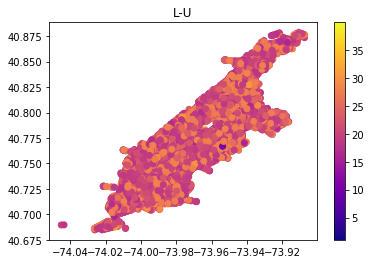

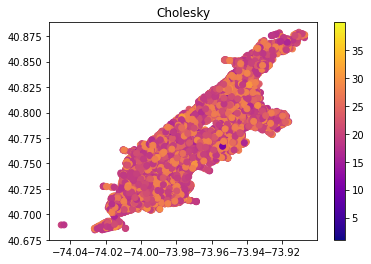

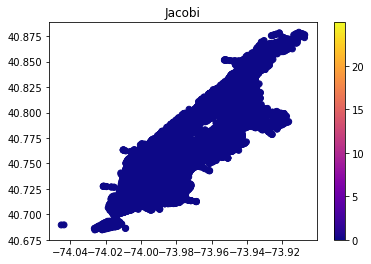

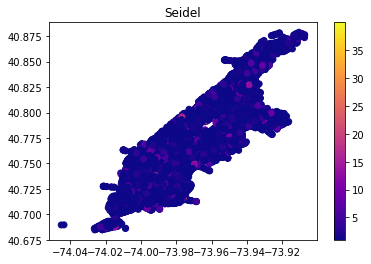

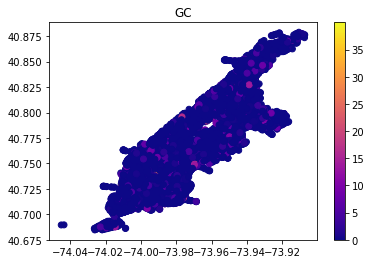

In [10]:
#Nesta célula de código, implementamos um algoritmo para imprimir um gráfico com as soluções obtidas em cada método
#a partir da utilização do grafo da maior componente conexa
v = []
xy = []

for i in list(grafo_maior_componente.nodes):
  v.append(i)

f = open('./dados/manh.xy','r')
for row in f:
    row = row.split('\t')
    row[1] = row[1].split('\n')
    aux = row[1]

    xy.append([float(row[0]), float(aux[0])])

vertices_x = []
vertices_y = []
vertices = []

for i in v:
    vertices.append(xy[i])
    vertices_x.append(xy[i][0])
    vertices_y.append(xy[i][1])

#Imprimindo os gráficos obtidos
plt.scatter(vertices_x, vertices_y, c=x_lu, cmap='plasma')
plt.title("L-U")
plt.colorbar()
plt.show()

plt.scatter(vertices_x, vertices_y, c=x_cho, cmap='plasma')
plt.title("Cholesky")
plt.colorbar()
plt.show()

plt.scatter(vertices_x, vertices_y, c=x_jaco, cmap='plasma')
plt.title("Jacobi")
plt.colorbar()
plt.show()

plt.scatter(vertices_x, vertices_y, c=x_seidel, cmap='plasma')
plt.title("Seidel")
plt.colorbar()
plt.show()

plt.scatter(vertices_x, vertices_y, c=x_cg, cmap='plasma')
plt.title("GC")
plt.colorbar()
plt.show()